In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import contextlib
import random
from surprise import Dataset, Reader, SVD, SVDpp, NMF, KNNBasic, SlopeOne, CoClustering, accuracy
from surprise.model_selection import KFold, cross_validate, train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split as train_test_split_sklearn
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import LeakyReLU, Dense, Dropout, Input, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from keras.losses import MeanSquaredError
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV as GridSearchCV2
from sklearn.ensemble import RandomForestRegressor
from keras.losses import MeanSquaredError

In [2]:
# adjust display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
data = pd.read_csv('order_clean_join_all.csv')
data.head()

/var/folders/bj/kty340bx2c5fb8txjv7svs8r0000gn/T/ipykernel_45823/498795085.py:1: DtypeWarning: Columns (14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('order_clean_join_all.csv')


,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,order_accepted_time,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,gender,dob,LOCATION_TYPE,latitude,longitude,latitude_vendor,longtitude_vendor,vendor_category_en,delivery_charge,vendor_tag_name
0,163238.0,92PEE24,1.0,7.6,2,0,0.0,0.0,No,No,0.0,0.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,Male,NaN,Other,-0.132100,-78.575297,-0.967769,0.080839,Restaurants,0.0,"American,Burgers,Free Delivery,Hot Dogs,Pasta"
1,163240.0,QS68UD8,1.0,8.7,1,0,0.0,0.0,No,No,0.0,0.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Unknown,NaN,Work,-0.393396,-78.544417,-1.271979,0.028832,Restaurants,0.0,"Burgers,Desserts,Free Delivery,Grills,Mexican"
2,163241.0,MB7VY5F,2.0,14.4,1,0,0.0,0.0,No,No,0.0,0.0,0.0,50.0,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,Unknown,NaN,Other,-1.072823,-78.464121,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic"
3,163244.0,KDJ951Y,1.0,7.1,1,0,0.0,0.0,No,No,0.0,0.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Male,NaN,Home,-0.292713,-78.556316,-0.601096,0.095998,Restaurants,0.0,"American,Burgers,Desserts,Mojitos ,Pasta"
4,163245.0,BAL0RVT,4.0,27.2,1,0,0.0,0.0,No,No,0.0,0.0,0.0,50.0,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Male,NaN,Work,-0.231810,-78.563513,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic"


# 1. Collaborative Filtering

In [4]:
data.vendor_category_en.value_counts()

vendor_category_en
Restaurants       120835
Sweets & Bakes     14381
Name: count, dtype: int64

In [5]:
# set default on predicting rating = 1 first -> means visited
data['rating'] = 1

In [6]:
# restaurants category
restaurants_rating = data[data['vendor_category_en'] == 'Restaurants'][['customer_id', 'vendor_id', 'rating']]
data_restaurant = restaurants_rating.groupby(['customer_id', 'vendor_id'], as_index=False)['rating'].sum()
data_restaurant['rating'].unique()

array([  1,   2,   4,  23,  10,   3,   6,   5,  13,  11,   7,   8,  15,
         9,  12,  14,  20,  21,  17,  19,  16,  26,  22,  61,  24,  25,
        29,  44,  18,  68,  35,  27,  30,  48,  33,  32,  28,  47,  34,
       114,  49,  37,  31,  74,  40,  56,  59,  42,  38, 141,  41,  43])

In [7]:
data_restaurant.describe()

,vendor_id,rating
count,62861.000000,62861.000000
mean,261.461463,1.922257
std,246.384334,2.403714
min,4.000000,1.000000
25%,84.000000,1.000000
50%,160.000000,1.000000
75%,356.000000,2.000000
max,907.000000,141.000000


In [8]:
min_rating = data_restaurant['rating'].min()
max_rating = data_restaurant['rating'].max()

In [9]:
# Dataset Reader
reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(data_restaurant[['customer_id', 'vendor_id', 'rating']], reader)

## 1.1 Memory-Based CF

In [10]:
# split into train test set
train, test = train_test_split(data, test_size = 0.2, random_state = 42)

In [11]:
# user based recommender
user_cf = KNNBasic(sim_options = {'name': 'pearson', 'user_based': True})

# item based recommender
item_cf = KNNBasic(sim_options= {'name': 'cosine', 'user_based': False})

In [12]:
user_cf.fit(train)
item_cf.fit(train)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [13]:
predictions = user_cf.test(test)
print(f"User Based Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

predictions = item_cf.test(test)
print(f"Item Based Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

User Based Model: RMSE: 2.8255232621517785, MAE: 1.366786360357639
Item Based Model: RMSE: 2.812093982592366, MAE: 1.2996645946530971


In [14]:
# k: # of neighbors when generating a prediction
# min_k: minimum number of neighbors to make a prediction
# sim_options: how to calculate the distance? cosine or pearson

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

param_grid = {
    'k': [100, 200, 300, 400, 500, 600, 700, 800],
    'min_k': [10, 20, 40, 60, 80],
    'sim_options': {
        'name': ['pearson'],
        'user_based': [True]
    }
}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# remove all the output here
with contextlib.redirect_stdout(None):
    gs.fit(data)

print("Best params: ", gs.best_params)
print("Best RMSE: ", gs.best_score)

Best params:  {'rmse': {'k': 200, 'min_k': 20, 'sim_options': {'name': 'pearson', 'user_based': True}}}
Best RMSE:  {'rmse': 2.377278195795899}


In [15]:
param_grid = {
    'k': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'min_k': [5, 10, 20, 30, 40],
    'sim_options': {
        'name': ['cosine'],
        'user_based': [False]
    }
}

gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3)

with contextlib.redirect_stdout(None):
    gs.fit(data)

print("Best params: ", gs.best_params)
print("Bes RMSE: ", gs.best_score)

Best params:  {'rmse': {'k': 30, 'min_k': 10, 'sim_options': {'name': 'cosine', 'user_based': False}}}
Bes RMSE:  {'rmse': 2.394952839172054}


## 1.2 Model-Based CF

### 1.2.1 Matrix Factorization

In [16]:
svd_cf = SVD()
nmf_cf = NMF()
svdpp_cf = SVDpp()

In [17]:
svd_cf.fit(train)
nmf_cf.fit(train)
svdpp_cf.fit(train)

In [18]:
predictions = svd_cf.test(test)
print(f"SVD Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

predictions = nmf_cf.test(test)
print(f"NMF Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

predictions = svdpp_cf.test(test)
print(f"SVD++ Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

SVD Model: RMSE: 2.636637690380186, MAE: 1.2008895829271546
NMF Model: RMSE: 2.815013570124813, MAE: 1.1785724203917527
SVD++ Model: RMSE: 2.6769991761543777, MAE: 1.347850443371472


In [19]:
# n_factors: number of dimensions on the user item matrix. higher dimension means more complex, but there is risk to overfit
# n_epochs: number of training iterations. too low may not identify the patterns
# lr_all: how is the rate of the model to update the weights. too high, may jump from the optimal solution.
# reg_all: regularization to prevent overfitting. 

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [10, 15, 20],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3)
gs.fit(data)

print("Best params: ", gs.best_params)
print("Best RMSE: ", gs.best_score)

Best params:  {'rmse': {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}}
Best RMSE:  {'rmse': 2.3467902672075636}


In [20]:
# lower value of n_factors for NMF than SVD because NFM can only handles positive values. this means fewer factors are make sense in this context
# n_factors and n_epochs are the same parameter as the SVD
# reg_pu: regularization for user factors
# reg_qi: regularization for item factors

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

param_grid = {
    'n_factors': [10, 20, 50],  
    'n_epochs': [10, 15, 20], 
    'reg_pu': [0.002, 0.01, 0.1],  
    'reg_qi': [0.002, 0.01, 0.1] 
}

gs = GridSearchCV(NMF, param_grid, measures = ['rmse'], cv = 3)
gs.fit(data)

print("Best params: ", gs.best_params)
print("Best RMSE: ", gs.best_score)

Best params:  {'rmse': {'n_factors': 50, 'n_epochs': 15, 'reg_pu': 0.1, 'reg_qi': 0.1}}
Best RMSE:  {'rmse': 2.4523464728691344}


In [21]:
# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# same parameter with SVD, but I reduced it here because it takes more time to run SVDpp. 
param_grid = {
    'n_factors': [20, 50], 
    'n_epochs': [10, 15], 
    'lr_all': [0.002, 0.005],  
    'reg_all': [0.02, 0.05]
}

gs = GridSearchCV(SVDpp, param_grid, measures = ['rmse'], cv = 3)
gs.fit(data)

print("Best params: ", gs.best_params)
print("Best RMSE: ", gs.best_score)

Best params:  {'rmse': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.05}}
Best RMSE:  {'rmse': 2.343832079597537}


### 1.2.2 Deep Learning

In [22]:
# Encode user_id and vendor_id
customer_id = data_restaurant['customer_id'].astype(str).values
vendor_id = data_restaurant['vendor_id'].astype(str).values
rating = data_restaurant['rating'].values

# Mapping user_id and vendor_id to unique indices
user_mapping = {str(user): idx for idx, user in enumerate(np.unique(customer_id))}
vendor_mapping = {str(vendor): idx for idx, vendor in enumerate(np.unique(vendor_id))}

user_ids_encoded = np.array([user_mapping[str(user)] for user in customer_id], dtype=np.int32)
vendor_ids_encoded = np.array([vendor_mapping[str(vendor)] for vendor in vendor_id], dtype=np.int32)

# Split data into training and testing
X_train_user, X_test_user, X_train_vendor, X_test_vendor, y_train, y_test = train_test_split_sklearn(
    user_ids_encoded, vendor_ids_encoded, rating, test_size=0.3, random_state=42
)

In [23]:
# Hyperparameters
n_users = len(user_mapping)
n_vendors = len(vendor_mapping)
embedding_size = 100  # Size of the embedding layer

# Build the Neural Network Model
user_input = Input(shape=(1,), name='user_input')
vendor_input = Input(shape=(1,), name='vendor_input')

user_embedding = Embedding(input_dim=n_users, output_dim=embedding_size)(user_input)
vendor_embedding = Embedding(input_dim=n_vendors, output_dim=embedding_size)(vendor_input)

user_embedding = Flatten()(user_embedding)
vendor_embedding = Flatten()(vendor_embedding)

# Concatenate the user and vendor embeddings
merged = Concatenate()([user_embedding, vendor_embedding])

In [24]:
# Fully connected layers with Dropout and L2 Regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(merged)
x = Dropout(0.4)(x)  
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)  
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
output = Dense(1)(x)

# Create the model
model = Model(inputs=[user_input, vendor_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit([X_train_user, X_train_vendor], y_train, epochs=20, batch_size=32, validation_data=([X_test_user, X_test_vendor], y_test), verbose =1)

# Evaluate the model
loss = model.evaluate([X_test_user, X_test_vendor], y_test)
print(f"Test Loss: {loss}")

Epoch 1/20


/opt/anaconda3/envs/zfq0/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'vendor_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 6.3772 - val_loss: 6.2170
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.1098 - val_loss: 6.3246
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.8577 - val_loss: 6.7333
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.6098 - val_loss: 7.3592
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.4193 - val_loss: 7.2176
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.1107 - val_loss: 7.2515
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.1632 - val_loss: 7.9120
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.7742 - val_loss: 7.3213
Epoch 9/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.9087 - val_loss: 8.1885
Epoch 10/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.9334 - val_loss: 7.6257
Epoch 11/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.2431 - val_loss: 7.8467
Epoch 12/20
1376/1376 ━━━━━━━━━━━━━━━━━━━

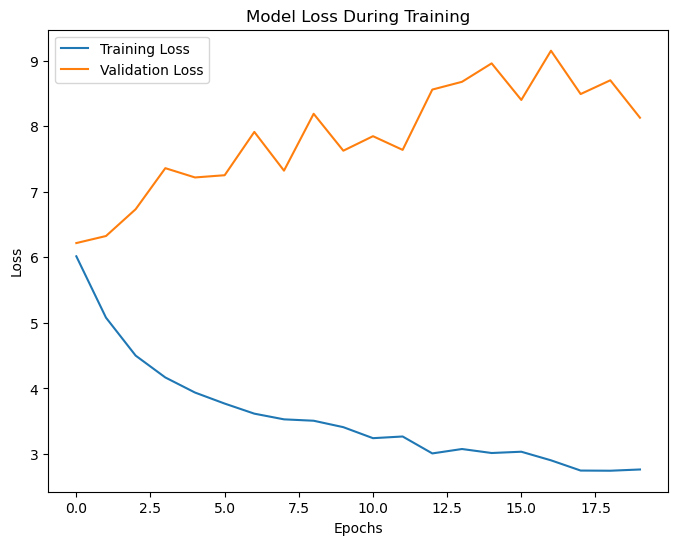

In [25]:
# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It shows overfitting, the validation loss fluctuates on the 6th epochs.

In [26]:
# Fully connected layers with Dropout and L2 Regularization
x = Dense(64, activation='relu', kernel_regularizer=l2(0.02))(merged)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)  

x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)  

x = Dense(16, activation='relu', kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1)(x)

# Create the model
model = Model(inputs=[user_input, vendor_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit([X_train_user, X_train_vendor], y_train, epochs=20, batch_size=32, validation_data=([X_test_user, X_test_vendor], y_test), callbacks=[early_stopping, lr_scheduler], verbose =1)

# Evaluate the model
loss = model.evaluate([X_test_user, X_test_vendor], y_test)
print(f"Test Loss: {loss}")

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 11.5386 - val_loss: 9.1986 - learning_rate: 5.0000e-04
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.9781 - val_loss: 8.7420 - learning_rate: 5.0000e-04
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.7020 - val_loss: 8.4254 - learning_rate: 5.0000e-04
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.6733 - val_loss: 8.0911 - learning_rate: 5.0000e-04
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.7751 - val_loss: 7.9535 - learning_rate: 5.0000e-04
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.8415 - val_loss: 8.2208 - learning_rate: 5.0000e-04
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.9991 - val_loss: 7.7058 - learning_rate: 5.0000e-04
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.4660 - val_loss: 7.9196 - learning_rate: 5.0000e-04
Epoch 9/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.7205 - 

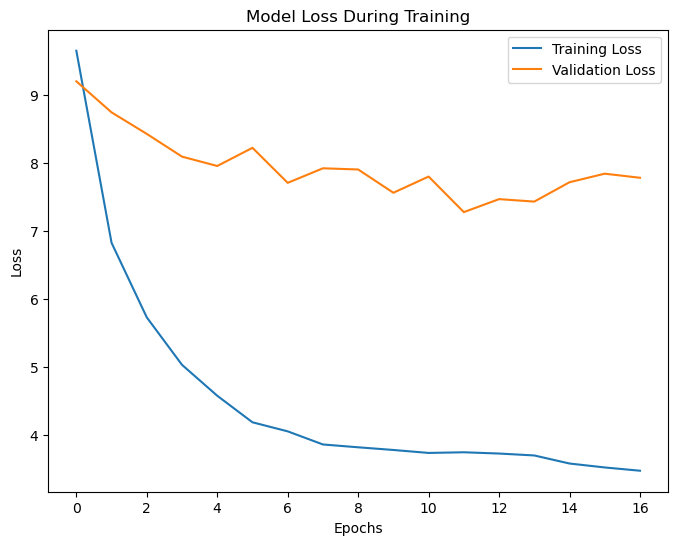

In [27]:
# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
x = Dense(32, kernel_regularizer=l2(0.0005))(merged)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)

x = Dense(16, kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)

output = Dense(1)(x)

# Create the model
model = Model(inputs=[user_input, vendor_input], outputs=output)

# Compile with gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

# Training callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model with proper validation split
history = model.fit(
    [X_train_user, X_train_vendor], 
    y_train, 
    epochs=20, 
    batch_size=64, 
    validation_data=([X_test_user, X_test_vendor], y_test),
    callbacks=[early_stopping, lr_scheduler], 
    verbose=1)

# Final evaluation on test set
loss = model.evaluate([X_test_user, X_test_vendor], y_test)
print(f"Test Loss: {loss}")

Epoch 1/20


/opt/anaconda3/envs/zfq0/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


688/688 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.7897 - val_loss: 8.2263 - learning_rate: 1.0000e-04
Epoch 2/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.6917 - val_loss: 7.2212 - learning_rate: 1.0000e-04
Epoch 3/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.6548 - val_loss: 7.0536 - learning_rate: 1.0000e-04
Epoch 4/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.0394 - val_loss: 7.1351 - learning_rate: 1.0000e-04
Epoch 5/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.8216 - val_loss: 7.1200 - learning_rate: 1.0000e-04
Epoch 6/20
678/688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5484
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.5525 - val_loss: 7.1590 - learning_rate: 1.0000e-04
Epoch 7/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.3244 - val_loss: 7.2447 - learning_rate: 5.0000e-05
Epoch 8/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.3580 - val_loss: 7.

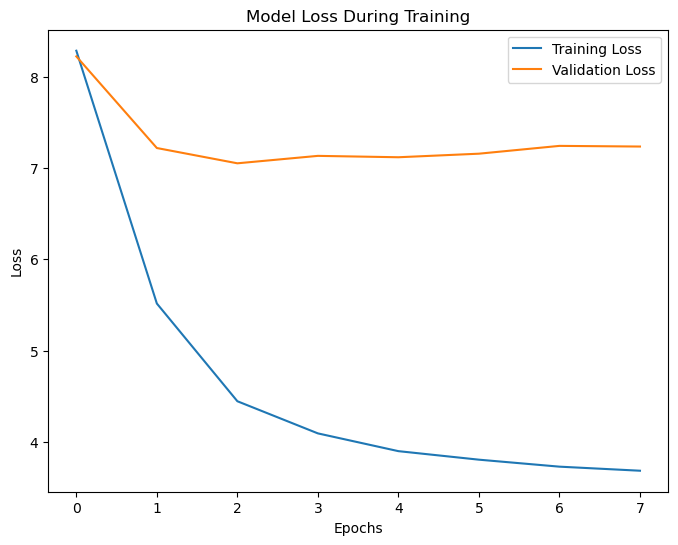

In [29]:
# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 1.3 Model Comparison and Evaluation

In [30]:
# create a model based on the best parameter based on the fine-tuning
user_tuned = KNNBasic(sim_options = {'k': 200, 'min_k': 20, 'name': 'pearson', 'user_based': True})
item_tuned = KNNBasic(sim_options = {'k': 30, 'min_k': 10, 'name': 'cosine', 'user_based': False})
svd_tuned = SVD(n_factors = 100, n_epochs = 20, lr_all = 0.005, reg_all = 0.1)
nmf_tuned = NMF(n_factors = 50, n_epochs = 15, reg_pu = 0.1, reg_qi = 0.1)
svdpp_tuned = SVDpp(n_factors = 20, n_epochs = 10, lr_all = 0.002, reg_all = 0.05)

user_tuned.fit(train)
item_tuned.fit(train)
svd_tuned.fit(train)
nmf_tuned.fit(train)
svdpp_tuned.fit(train)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [31]:
# predict the test set from a given model
predictions = user_tuned.test(test)
print(f"User Based Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

predictions = item_tuned.test(test)
print(f"Item Based Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

predictions = svd_tuned.test(test)
print(f"SVD Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

predictions = nmf_tuned.test(test)
print(f"NMF Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

predictions = svdpp_tuned.test(test)
print(f"SVD++ Model: RMSE: {accuracy.rmse(predictions, verbose = False)}, MAE: {accuracy.mae(predictions, verbose = False)}")

User Based Model: RMSE: 2.8255232621517785, MAE: 1.366786360357639
Item Based Model: RMSE: 2.812093982592366, MAE: 1.2996645946530971
SVD Model: RMSE: 2.600153759558708, MAE: 1.1542170157922553
NMF Model: RMSE: 2.6802086621068484, MAE: 1.0932162278770348
SVD++ Model: RMSE: 2.6053699603306897, MAE: 1.2086720131060933


In [32]:
X_test_user_encoded = np.array([user_mapping.get(str(user), -1) for user in X_test_user], dtype=np.int32)
X_test_vendor_encoded = np.array([vendor_mapping.get(str(vendor), -1) for vendor in X_test_vendor], dtype=np.int32)

X_test = [X_test_user_encoded.reshape(-1, 1), X_test_vendor_encoded.reshape(-1, 1)]

y_pred_dl = model.predict(X_test, verbose=0).flatten()

rmse_dl = root_mean_squared_error(y_test, y_pred_dl)
mae_dl = mean_absolute_error(y_test, y_pred_dl)

print(f"RMSE: {rmse_dl:.4f}, MAE: {mae_dl:.4f}")

RMSE: 3.0611, MAE: 2.3609


# 2. Hybrid Model

## 2.1 Weighted Hybrid

### 2.1.1  SVD and SVD++

In [34]:
# set alpha for the hybrid model. It will be alpha * model_1 + (1-alpha) * model_2
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# create a variable for the best alpha, beta and rmse
best_alpha = None
best_beta = None
best_rmse = float("inf")

# use for loop to test each alpha value
for a in alpha:
    # beta is the weight for second model = 1-alpha
    beta = 1-a
    pred = []

    # for every input of the test model, fit the 2 model that will be concatenate together for the hybrid model
    # calculate the pred by using the multiplication of a * model_1 + b * model_2
    for user_id, item_id, true_r in test:
        svd_pred = svd_tuned.predict(user_id, item_id).est
        svdpp_pred = svdpp_tuned.predict(user_id, item_id).est
        hybrid_pred = (a * svd_pred) + (beta * svdpp_pred)
        pred.append((user_id, item_id, true_r, hybrid_pred))

    # calculate the rmse for the hybrid model
    rmse = np.sqrt(np.mean([(true_r - predict) ** 2 for user_id, item_id, true_r, predict in pred]))

    # print the value
    print(f"Alpha: {a}, Beta: {beta}, RMSE: {rmse}")

    # check whether the rmse is better (lower) than the previous model. If yes, then, change the best_rmse, alpha, and beta
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = a
        best_beta = beta

print("\nBest Alpha: ", best_alpha)
print("Best Beta: ", best_beta)
print("Best RMSE: ", best_rmse)

Alpha: 0.1, Beta: 0.9, RMSE: 2.5992591391151687
Alpha: 0.2, Beta: 0.8, RMSE: 2.594380040130667
Alpha: 0.3, Beta: 0.7, RMSE: 2.5907396224355628
Alpha: 0.4, Beta: 0.6, RMSE: 2.5883431125260823
Alpha: 0.5, Beta: 0.5, RMSE: 2.5871939670885404
Alpha: 0.6, Beta: 0.4, RMSE: 2.5872938481726337
Alpha: 0.7, Beta: 0.30000000000000004, RMSE: 2.58864261119975
Alpha: 0.8, Beta: 0.19999999999999996, RMSE: 2.591238306007506
Alpha: 0.9, Beta: 0.09999999999999998, RMSE: 2.595077190912965

Best Alpha:  0.5
Best Beta:  0.5
Best RMSE:  2.5871939670885404


### 2.1.2 SVD++ and Item Based

In [35]:
# set alpha for the hybrid model. It will be alpha * model_1 + (1-alpha) * model_2
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# create a variable for the best alpha, beta and rmse
best_alpha = None
best_beta = None
best_rmse = float("inf")

# use for loop to test each alpha value
for a in alpha:
    # beta is the weight for second model = 1-alpha
    beta = 1-a
    pred = []

    # for every input of the test model, fit the 2 model that will be concatenate together for the hybrid model
    # calculate the pred by using the multiplication of a * model_1 + b * model_2
    for user_id, item_id, true_r in test:
        item_pred = item_tuned.predict(user_id, item_id).est
        svd_pred = svdpp_tuned.predict(user_id, item_id).est
        hybrid_pred = (a * item_pred) + (beta * svdpp_pred)
        pred.append((user_id, item_id, true_r, hybrid_pred))

    # calculate the rmse for the hybrid model
    rmse = np.sqrt(np.mean([(true_r - predict) ** 2 for user_id, item_id, true_r, predict in pred]))

    # print the value
    print(f"Alpha: {a}, Beta: {beta}, RMSE: {rmse}")

    # check whether the rmse is better (lower) than the previous model. If yes, then, change the best_rmse, alpha, and beta
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = a
        best_beta = beta

print("\nBest Alpha: ", best_alpha)
print("Best Beta: ", best_beta)
print("Best RMSE: ", best_rmse)

Alpha: 0.1, Beta: 0.9, RMSE: 2.748208727836119
Alpha: 0.2, Beta: 0.8, RMSE: 2.7199384190020472
Alpha: 0.3, Beta: 0.7, RMSE: 2.700368976007899
Alpha: 0.4, Beta: 0.6, RMSE: 2.6896903208403766
Alpha: 0.5, Beta: 0.5, RMSE: 2.688008416927433
Alpha: 0.6, Beta: 0.4, RMSE: 2.695340106357062
Alpha: 0.7, Beta: 0.30000000000000004, RMSE: 2.7116122769332147
Alpha: 0.8, Beta: 0.19999999999999996, RMSE: 2.7366654534134836
Alpha: 0.9, Beta: 0.09999999999999998, RMSE: 2.770261409941773

Best Alpha:  0.5
Best Beta:  0.5
Best RMSE:  2.688008416927433


### 2.1.3 Deep Learning and SVD++

In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Define weight combinations to test
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

best_alpha = None
best_beta = None
best_rmse = float("inf")

# Get the test data in the right format
test_users = np.array([user_id for user_id, item_id, _ in test], dtype=str)
test_items = np.array([item_id for user_id, item_id, _ in test], dtype=str)
y_true = np.array([true_r for _, _, true_r in test])

# Get SVD++ predictions
svdpp_predictions = []
for user, item in zip(test_users, test_items):
    try:
        pred = svdpp_tuned.predict(user, item).est
        svdpp_predictions.append(pred)
    except Exception as e:
        # Use global mean for any prediction failures
        svdpp_predictions.append(svdpp_tuned.trainset.global_mean)
svdpp_predictions = np.array(svdpp_predictions)

# Get deep learning predictions
user_indices = []
item_indices = []
valid_indices = []  # To track which test samples have valid mappings

for i, (user, item) in enumerate(zip(test_users, test_items)):
    if user in user_mapping and item in vendor_mapping:
        user_indices.append(user_mapping[user])
        item_indices.append(vendor_mapping[item])
        valid_indices.append(i)

user_input = np.array(user_indices, dtype=np.int32).reshape(-1, 1)
item_input = np.array(item_indices, dtype=np.int32).reshape(-1, 1)

dl_predictions_valid = model.predict([user_input, item_input], verbose=0).flatten()

# Create a full array of predictions, matching the size of svdpp_predictions
dl_predictions = np.zeros_like(svdpp_predictions)
for i, valid_idx in enumerate(valid_indices):
    dl_predictions[valid_idx] = dl_predictions_valid[i]

# For any test samples where we couldn't make a deep learning prediction,
# use the SVD++ prediction as a fallback
invalid_indices = list(set(range(len(test_users))) - set(valid_indices))
for idx in invalid_indices:
    dl_predictions[idx] = svdpp_predictions[idx]

# Normalize predictions to similar scales if needed
dl_mean = np.mean(dl_predictions)
dl_std = np.std(dl_predictions)
svdpp_mean = np.mean(svdpp_predictions)
svdpp_std = np.std(svdpp_predictions)

dl_predictions_normalized = (dl_predictions - dl_mean) / dl_std
svdpp_predictions_normalized = (svdpp_predictions - svdpp_mean) / svdpp_std

# Scale back to original range (centered on SVD++ mean)
dl_predictions_scaled = dl_predictions_normalized * svdpp_std + svdpp_mean

for alpha in alpha_values:
    beta = 1 - alpha
    hybrid_predictions = (alpha * svdpp_predictions) + (beta * dl_predictions_scaled)
    rmse = np.sqrt(mean_squared_error(y_true, hybrid_predictions))

    print(f"Alpha (SVD++): {alpha:.1f}, Beta (DL): {beta:.1f}, RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha_norm = alpha
        best_beta_norm = beta

print(f"Best Alpha (SVD++): {best_alpha_norm:.1f}")
print(f"Best Beta (DL): {best_beta_norm:.1f}")
print(f"Best RMSE: {best_rmse:.4f}")


Alpha (SVD++): 0.1, Beta (DL): 0.9, RMSE: 2.6187
Alpha (SVD++): 0.2, Beta (DL): 0.8, RMSE: 2.6232
Alpha (SVD++): 0.3, Beta (DL): 0.7, RMSE: 2.6277
Alpha (SVD++): 0.4, Beta (DL): 0.6, RMSE: 2.6323
Alpha (SVD++): 0.5, Beta (DL): 0.5, RMSE: 2.6370
Alpha (SVD++): 0.6, Beta (DL): 0.4, RMSE: 2.6417
Alpha (SVD++): 0.7, Beta (DL): 0.3, RMSE: 2.6464
Alpha (SVD++): 0.8, Beta (DL): 0.2, RMSE: 2.6512
Alpha (SVD++): 0.9, Beta (DL): 0.1, RMSE: 2.6560
Best Alpha (SVD++): 0.1
Best Beta (DL): 0.9
Best RMSE: 2.6187


## 2.2 Stacked Model

### 2.2.1 Random Forest

In [37]:
df = pd.read_csv("order_clean_join_all.csv")

vendor_tags = df['vendor_tag_name'].dropna().tolist()  # Drop missing values
all_tags = set()

# Collect all unique tags
for tags in vendor_tags:
    tag_list = [tag.strip() for tag in tags.split(',')]  # Split and clean
    all_tags.update(tag_list)

# Convert to sorted list for consistency
all_tags = sorted(all_tags)
print("Unique Tags:", all_tags)

Unique Tags: ['American', 'Arabic', 'Asian', 'Bagels', 'Biryani', 'Breakfast', 'Burgers', 'Cafe', 'Cakes', 'Chinese', 'Churros', 'Coffee', 'Combos', 'Crepes', 'Desserts', 'Dimsum', 'Donuts', 'Family Meal', 'Fatayers', 'Free Delivery', 'Fresh Juices', 'Fries', 'Frozen yoghurt', 'Grills', 'Healthy Food', 'Hot Chocolate', 'Hot Dogs', 'Ice creams', 'Indian', 'Italian', 'Japanese', 'Karak', 'Kebabs', 'Kids meal', 'Kushari', 'Lebanese', 'Manakeesh', 'Mandazi', 'Mexican', 'Milkshakes', 'Mishkak', 'Mojitos', 'Omani', 'Organic', 'Pancakes', 'Pasta', 'Pastas', 'Pastry', 'Pizza', 'Pizzas', 'Rice', 'Rolls', 'Salads', 'Sandwiches', 'Seafood', 'Shawarma', 'Shuwa', 'Smoothies', 'Soups', 'Spanish Latte', 'Steaks', 'Sushi', 'Sweets', 'Thai', 'Thali', 'Vegetarian', 'Waffles']


/var/folders/bj/kty340bx2c5fb8txjv7svs8r0000gn/T/ipykernel_45823/1507662987.py:1: DtypeWarning: Columns (14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("order_clean_join_all.csv")


In [38]:
# Convert each vendor's tags into a list
df['vendor_tag_list'] = df['vendor_tag_name'].apply(lambda x: [tag.strip() for tag in x.split(',')] if pd.notna(x) else [])

# Use MultiLabelBinarizer to create binary features for each tag
mlb = MultiLabelBinarizer()
tag_encoded = pd.DataFrame(mlb.fit_transform(df['vendor_tag_list']), columns=mlb.classes_)

# Merge with the original dataframe
df = df.join(tag_encoded)
df.drop(columns=['vendor_tag_name', 'vendor_tag_list'], inplace=True)  # Drop original tag columns

In [39]:
X_train_tags = tag_encoded.iloc[X_train_vendor].values  # Get one-hot tag encoding for training
X_test_tags = tag_encoded.iloc[X_test_vendor].values  # Get one-hot tag encoding for testing

In [40]:
# Prepare inputs
X_train_user_encoded = np.array([user_mapping.get(str(user), 0) for user in X_train_user], dtype=np.int32)
X_train_vendor_encoded = np.array([vendor_mapping.get(str(vendor), 0) for vendor in X_train_vendor], dtype=np.int32)
X_test_user_encoded = np.array([user_mapping.get(str(user), 0) for user in X_test_user], dtype=np.int32)
X_test_vendor_encoded = np.array([vendor_mapping.get(str(vendor), 0) for vendor in X_test_vendor], dtype=np.int32)

# Get deep learning predictions for training set
dl_train_preds = model.predict(
    [X_train_user_encoded.reshape(-1, 1), X_train_vendor_encoded.reshape(-1, 1)], 
    verbose=0
).flatten()

# Get SVD++ predictions for training set
svdpp_train_preds = []
for user, vendor in zip(X_train_user, X_train_vendor):
    try:
        pred = svdpp_tuned.predict(str(user), str(vendor)).est
        svdpp_train_preds.append(pred)
    except:
        # If prediction fails, use global mean
        svdpp_train_preds.append(svdpp_tuned.trainset.global_mean)
svdpp_train_preds = np.array(svdpp_train_preds)

# Create combined feature vectors for training
features_train = np.column_stack([
    dl_train_preds,       
    svdpp_train_preds,            
    X_train_tags
])

# Train a Random Forest model to combine these signals
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 5, 7]
}

# Create grid search with cross-validation
grid_search = GridSearchCV2(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error', # GridSearchCV from sckitlearn will automatically calculate the higher score the better. For RMSE we want lower is the best one, so need to take the negative of it
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(features_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")
best_rf_model = grid_search.best_estimator_

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


In [41]:
# Now prepare test data in the same way
dl_test_preds = model.predict(
    [X_test_user_encoded.reshape(-1, 1), X_test_vendor_encoded.reshape(-1, 1)], 
    verbose=0
).flatten()

svdpp_test_preds = []
for user, vendor in zip(X_test_user, X_test_vendor):
    try:
        pred = svdpp_tuned.predict(str(user), str(vendor)).est
        svdpp_test_preds.append(pred)
    except:
        svdpp_test_preds.append(svdpp_tuned.trainset.global_mean)
svdpp_test_preds = np.array(svdpp_test_preds)

features_test = np.column_stack([
    dl_test_preds,
    svdpp_test_preds,
    X_test_tags
])

In [42]:
# Make predictions on test data
rf_predictions = best_rf_model.predict(features_test)

# Calculate the combined RMSE on the test set
combined_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print(f"Combined Test Set RMSE: {combined_rmse:.4f}")

feature_names = ['DL_Score', 'SVD++_Score'] + list(mlb.classes_)
feature_importances = pd.DataFrame({
    'Feature': feature_names[:features_train.shape[1]], 
    'Importance': best_rf_model.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(feature_importances.sort_values('Importance', ascending=False).head(10))

Combined Test Set RMSE: 2.4803

Top 10 Most Important Features:
          Feature  Importance
0        DL_Score    0.504546
8         Burgers    0.089858
23          Fries    0.060701
44          Omani    0.047566
54         Salads    0.032818
7       Breakfast    0.028101
3          Arabic    0.024187
21  Free Delivery    0.018604
63          Sushi    0.016289
40        Mexican    0.015999


### 2.2.2 Neural Network

In [43]:
# Create input layer for the features
input_features = Input(shape=(features_train.shape[1],))

# Fully connected layers with Dropout and L2 Regularization
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(input_features)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(16, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(1)(x)

# Create the model
nn_combiner = Model(inputs=input_features, outputs=output)

# Compile the model
nn_combiner.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = nn_combiner.fit(
    features_train, y_train,
    epochs=50,
    batch_size=8,
    validation_split=0.3,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate on test set
nn_predictions = nn_combiner.predict(features_test).flatten()
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_predictions))
print(f"Neural Network Ensemble RMSE: {nn_rmse:.4f}")

Epoch 1/50
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 5s 866us/step - loss: 7.7767 - val_loss: 7.4276 - learning_rate: 5.0000e-04
Epoch 2/50
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 3s 832us/step - loss: 5.4078 - val_loss: 7.3294 - learning_rate: 5.0000e-04
Epoch 3/50
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 3s 843us/step - loss: 5.1164 - val_loss: 7.2311 - learning_rate: 5.0000e-04
Epoch 4/50
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 3s 822us/step - loss: 5.2815 - val_loss: 7.1707 - learning_rate: 5.0000e-04
Epoch 5/50
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 3s 819us/step - loss: 4.9163 - val_loss: 7.1005 - learning_rate: 5.0000e-04
Epoch 6/50
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 3s 823us/step - loss: 4.7841 - val_loss: 7.0668 - learning_rate: 5.0000e-04
Epoch 7/50
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 3s 829us/step - loss: 4.9701 - val_loss: 7.0520 - learning_rate: 5.0000e-04
Epoch 8/50
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 3s 820us/step - loss: 5.0205 - val_loss: 7.0383 - learning_rate: 5.0000e-04
Epoch 9/50
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 3s 819us/step 

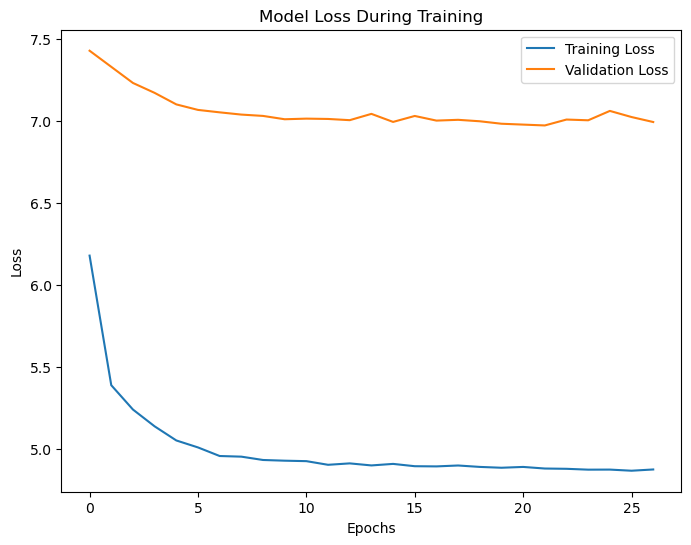

In [44]:
# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Cold Sart Problem

We ask users to select top N favourite restaurant types. We transform their selection into vendor tag vector and match it with vendors using cosine similarity and Random Forest model.

In [ ]:
# Create a cold-start specific dataset
# Use only the tag features for training
cold_start_features = X_train_tags
cold_start_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=30,
    random_state=42
)
cold_start_model.fit(cold_start_features, y_train)

# For new users:
def recommend_for_new_user(user_selected_tags, top_n=10):
    # Convert user's selected tags to binary vector
    user_tag_vector = np.zeros(len(mlb.classes_))
    for tag in user_selected_tags:
        if tag in mlb.classes_:
            idx = np.where(mlb.classes_ == tag)[0][0]
            user_tag_vector[idx] = 1
    
    # Get all vendors
    all_vendors = list(vendor_mapping.keys())
    vendor_scores = []
    
    # Score each vendor based on tag matching and similarity
    for vendor_id in all_vendors:
        vendor_idx = vendor_mapping.get(vendor_id)
        if vendor_idx is not None and vendor_idx < len(tag_encoded):
            vendor_tag_vector = tag_encoded.iloc[vendor_idx].values
            
            # Calculate similarity between user preferences and vendor tags
            similarity = np.dot(user_tag_vector, vendor_tag_vector) / (np.linalg.norm(user_tag_vector) * np.linalg.norm(vendor_tag_vector) + 1e-8)
            
            # Use the cold start model to predict based on vendor tags and/or similarity
            predicted_score = cold_start_model.predict([vendor_tag_vector])[0] * (1 + similarity)
            vendor_scores.append((vendor_id, predicted_score))
    
    # Sort and return top N recommendations
    vendor_scores.sort(key=lambda x: x[1], reverse=True)
    return vendor_scores[:top_n]

In [46]:
recommend_for_new_user(['Salads'], 10)

[('106', 3.587728209596047),
 ('113', 3.587728209596047),
 ('13', 3.587728209596047),
 ('149', 3.587728209596047),
 ('154', 3.587728209596047),
 ('176', 3.587728209596047),
 ('180', 3.587728209596047),
 ('20', 3.587728209596047),
 ('67', 3.0273279658709153),
 ('157', 2.9068127388867797)]

In [47]:
recommend_for_new_user(['American'], 10)

[('110', 3.2331936879441874),
 ('157', 2.9068127388867797),
 ('160', 2.9068127388867797),
 ('104', 2.8809810575641697),
 ('134', 2.8809810575641697),
 ('145', 2.8809810575641697),
 ('92', 2.8809810575641697),
 ('855', 2.6599800459986342),
 ('216', 2.456637235817597),
 ('310', 2.456637235817597)]